# Diagnose a FELTOR magnetic field and calibrate box, wall and sheath regions
In this notebook we diagnose the magnetic field as defined by a FELTOR magnetic field parameter file.
In this way the consistency of for example a freshly generated magnetic parameters file can be checked.

In particular, this notebook explains how to calibrate the simulation box, wall and sheath regions that are usable for a 3d simulation setup.

## The geometry_diag program
This notebook uses the *feltor/src/geometry_diag/geometry_diag.cpp* program. At this
At this point **please read the documentation "feltor/src/geometry_diag/geometry_diag.tex" (compile to pdf)** and **compile the geometry_diag program (using make)** 

The program is called using the "geometry_diag.sh" bash script in this repository using the *simplesimdb* python package .

## Note
A lot of the functionality and motivation for the `geometry_diag.cpp` program is now being replaced by the new `pyfeltor.dg.geo` package, which should be the preferred solution. For the time being we keep `geometry_diag.cpp` until
the `pyfeltor.dg.geo` package is fully tried and tested.


## Setup the diagnostics run
Once *geometry_diag* is compiled we can start.

In [1]:
import json
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import numpy as np
import magneticfielddb as mag
import simplesimdb as simplesim

In [2]:
help(mag)

Help on module magneticfielddb:

NAME
    magneticfielddb - Storage and Access to magnetic field coefficients for Feltor

FUNCTIONS
    files()
        Create a list of available files
        
        Return:
        list:   A list of file paths relative to path/to/magneticfielddb/data
                of all files in the data repository
                each item in the list can be passed to the select function
    
    select(path, *paths)
        Select a file in the data folder
        
        The file is then opened and its contents returned as a dictionary
        Parameters:
        path, *paths (pathlike): one or more path indicators to a file
            relative to path/to/magneticfielddb/data (forwarded to
            os.path.join(path,*paths) )
        Return:
        dict : A dictionary containing the contents of the chosen file

FILE
    /home/matthias/Projekte/magneticfielddb/magneticfielddb.py




In [3]:
mag.files()

['circular.json',
 'COMPASS/compass_1X.json',
 'COMPASS/compass_-1X.json',
 'COMPASS/compass_2X.json',
 'COMPASS/Iconst_woX.json',
 'COMPASS/Iconst.json',
 'COMPASS/woX_circ_Taylor.json',
 'COMPASS/Iconst_woX_circ.json',
 'COMPASS/woX_Taylor.json',
 'COMPASS/compass_-2X.json',
 'enrx_tcv.json',
 'toroidal.json',
 'AUG/falchetto_Iconst_Te_150eV_B0_2T.json',
 'AUG/Iconst_Te_70eV_B0_2T.json',
 'guenter.json',
 'TJ-K/Taylor.json',
 'TJ-K/Taylor_circ.json',
 'TJ-K/Taylor_elong.json',
 'TJ-K/woX_rfp_elong.json',
 'TJ-K/rfp_elong.json',
 'TJ-K/Iconst_elong_d_e_AUG.json',
 'TJ-K/Iconst_elong.json',
 'TJ-K/Iconst.json',
 'enrx_torpex.json']

The first step is to select a parameters file. We can either use a self-generated file or use one of the files contained in the Magneticfield-database (the *magneticfielddb* python package obtained at https://github.com/feltor-dev/magneticfielddb )

In [4]:
# Select your file
#
# READ your own file
# Replace tcv.json with your own parameters file
# with open("tcv.json","r") as f:
#     magparams = json.load(f)
#
# OR use one of the magneticfieldb premade files
# magparams  = mag.select("enrx_tcv.json")
magparams = mag.select("COMPASS/compass_2X.json")

As a next step we generate a default input file for *geoemtry_diag* and run our first simulation. Please read the documentation for further details on the input parameters.

In [5]:
# A generic input file for geometry_diag
# Compile the code with make geometry_diag
def make_inputfile():
    return {
        "grid": {
            "type": "Cartesian2d",
            "n": 3,
            "Nx": 80,
            "Ny": 80,
            "Nz": 20,
            "npsi": 3,
            "Npsi": 32,
            "Neta": 640,
            "fx_0": 0.0625,
            "scaleR": [
                1.0,
                1.0,
            ],  # The box is [ R_0 - scaleR[0]*a , R_0 + scaleR[1]*a ]
            "scaleZ": [1.0, 1.0],  # The box is [ -scaleZ[0]*a , scaleZ[1]*a ]
        },
        "boundary": {
            "wall": {"type": "heaviside", "boundary": 1.1, "alpha": 0.2},
            #         "sheath": # only if "sheath" is in "diagnostics"
            #         {
            #             "boundary" : 3/32,
            #             "alpha" : 2/32,
            #             "max_angle" : 1e-3
            #         }
        },
        "diagnostics": [],  # "q-profile", "fsa", "sheath"
        # NOTE: by default only the standard basic diagnostics is run that has little danger of failing
        # ALL of the following can fail and should only be attempted once the parameters are tuned!
        # q-profile: integrate field-lines within LCFS to get q-profile (
        #      can fail e.g. if Psi_p = 0 is not a closed flux-surface)
        # fsa: compute a flux-aligned grid and compute flux-surface averaged quantities
        # sheath: integrate field-lines to get distance to divertor
        "magnetic_field": {"input": "params", "params": magparams},
        "width-factor": 0.03,
    }

In [6]:
# Setup simplesimdb using the Repeater,
# which will overwrite temp.json and temp.nc in each simulation
ncfile = "temp.nc"
rep = simplesim.Repeater("./geometry_diag.sh", "temp.json", ncfile)

In [7]:
# our first run
ifile = make_inputfile()
rep.run(ifile)

In [8]:
# First, display the contents of the file
# You can read up on any field in the documentation
# https://mwiesenberger.github.io/feltor/geometries/html/modules.html
ncin = Dataset(ncfile, "r", format="NETCDF4")
print("FILE CONTENTS")
for v in ncin.variables:
    print(f"{v} {ncin.variables[v].shape}", f"\t{ ncin.variables[v].long_name}")

FILE CONTENTS
zeta (96,) 	zeta-coordinate in Computational coordinate system
z (20,) 	z-coordinate in Computational coordinate system
y (240,) 	y-coordinate in Computational coordinate system
x (240,) 	x-coordinate in Computational coordinate system
Psip (240, 240) 	Flux function
Psip3d (20, 240, 240) 	Flux function
modPsip (240, 240) 	Modified Flux function
modPsip3d (20, 240, 240) 	Modified Flux function
PsipR (240, 240) 	Flux function derivative in R
PsipR3d (20, 240, 240) 	Flux function derivative in R
PsipZ (240, 240) 	Flux function derivative in Z
PsipZ3d (20, 240, 240) 	Flux function derivative in Z
PsipRR (240, 240) 	Flux function derivative in RR
PsipRR3d (20, 240, 240) 	Flux function derivative in RR
PsipRZ (240, 240) 	Flux function derivative in RZ
PsipRZ3d (20, 240, 240) 	Flux function derivative in RZ
PsipZZ (240, 240) 	Flux function derivative in ZZ
PsipZZ3d (20, 240, 240) 	Flux function derivative in ZZ
Ipol (240, 240) 	Poloidal current
Ipol3d (20, 240, 240) 	Poloidal cu

In [9]:
# And file attributes
ncin.ncattrs()

['Conventions',
 'comment',
 'compile-time',
 'git-branch',
 'git-hash',
 'history',
 'inputfile',
 'opoint',
 'references',
 'source',
 'title',
 'xpoint']

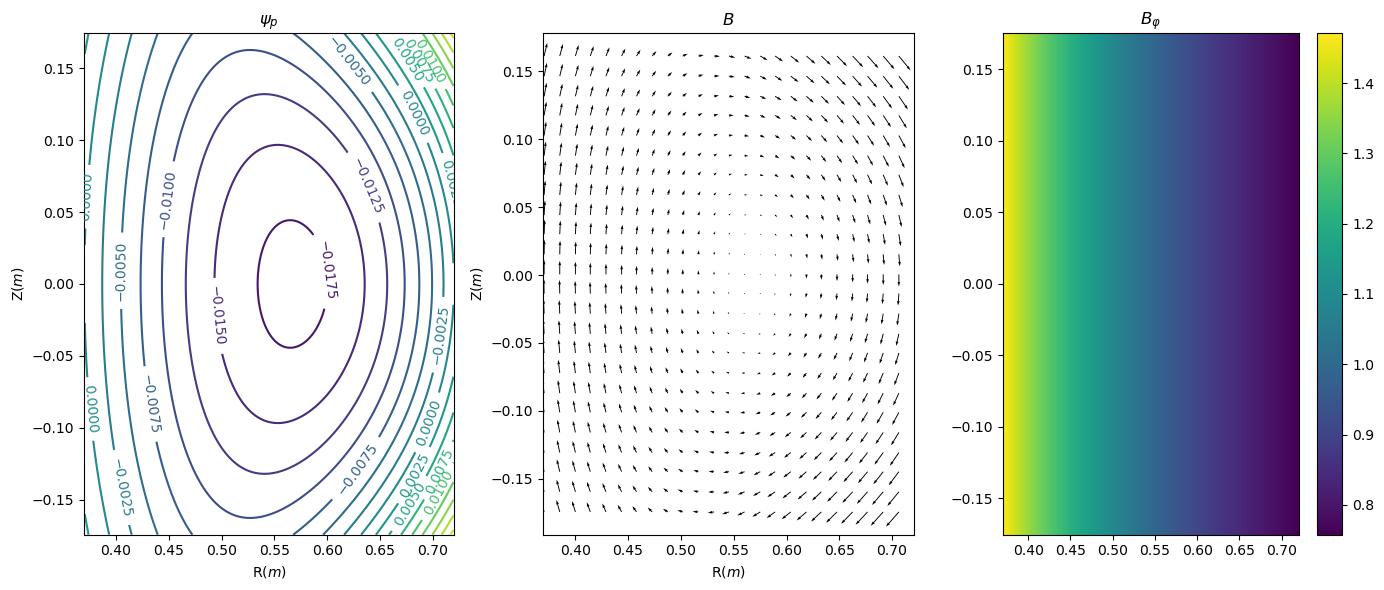

In [10]:
# Now let us plot the flux function
# which is what we want to fit
# and the B - field

fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, figsize=(14, 6), squeeze=False)
R = ncin["x"][:]
Z = ncin["y"][:]
Psi = ncin["Psip"][:, :]
ax = axes[0][0]
cf = ax.contour(R, Z, Psi, 15)
ax.clabel(cf)
ax.set_xlabel(r"R($m$)")
ax.set_ylabel(r"Z($m$)")
ax.set_title(r"$\psi_p$")
ax = axes[0][1]
BR = ncin["BFieldR"][:, :]
BZ = ncin["BFieldZ"][:, :]
Bphi = ncin["BFieldP"][:, :]
q = ax.quiver(R[::10], Z[::10], BR[::10, ::10], BZ[::10, ::10], units="width")
ax.set_xlabel(r"R($m$)")
ax.set_ylabel(r"Z($m$)")
ax.set_title(r"$B$")
ax = axes[0][2]
cf = ax.pcolormesh(R, Z, Bphi * R[None, :])
fig.colorbar(cf, ax=ax)
ax.set_title(r"$B_\varphi$")
fig.tight_layout()

plt.show()

In [11]:
ncin.close()

## Calibrate box,  wall and sheath
Our next goal is to calibrate the numerical box, the wall and the sheath region. To this end we first define a plotting routine and then apply it to our initial simulation: 

In [12]:
# Define a plotting routine
def plot(f, plot_sheath=False):
    ncin = Dataset(f, "r", format="NETCDF4")
    pp = json.loads(ncin.inputfile)
    grid_ratio = (pp["grid"]["scaleZ"][1] + pp["grid"]["scaleZ"][0]) / (
        pp["grid"]["scaleR"][1] + pp["grid"]["scaleR"][0]
    )
    print("Z:R =", grid_ratio)
    p = pp["magnetic_field"]["params"]
    equi = p["equilibrium"]
    desc = p["description"]

    xc = ncin["x"][:]
    yc = ncin["y"][:]
    if type(pp["boundary"]["wall"]["boundary"]) is list:
        lvls = pp["boundary"]["wall"]["boundary"]
    else:
        lvls = [pp["boundary"]["wall"]["boundary"]]
    print(lvls)
    lvls.append(1)
    lvls = sorted(lvls)
    print("Wall levels = ", lvls)

    frows = 1
    fcols = 2
    fig, axs = plt.subplots(
        frows,
        fcols,
        figsize=(fcols * 8, frows * 6 * grid_ratio),
        dpi=80,
        facecolor="w",
        edgecolor="k",
    )
    # im = ax[0][0].pcolormesh(xc,yc,ncin["Psip"][:,:], shading='gouraud', cmap='seismic' )

    # https://matplotlib.org/stable/tutorials/colors/colormaps.html
    ax = axs[0]
    # im = ax[0][0].contourf(xc,yc,ncin["Psip2d"][:,:],cmap="twilight_r")
    im = ax.pcolormesh(
        xc, yc, ncin["modPsip"][:, :], cmap="gist_ncar", shading="gouraud"
    )
    fig.colorbar(im, ax=ax)
    im = ax.contour(xc, yc, ncin["Rho_p"][:, :], levels=lvls, linewidths=2, colors="k")

    ax.axis("scaled")
    start, end = ax.get_xlim()
    #     ax.xaxis.set_ticks(np.arange(start, end, 20))
    ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
    ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
    ax.xaxis.grid(which="both")
    ax.yaxis.grid(which="both")
    ax.set_title(r"$\psi_p$")
    ax.set_xlabel("R [mm]")
    ax.set_ylabel("Z [mm]")

    ax = axs[1]
    plot = ncin["MagneticTransition"][:, :]
    plot = np.ma.masked_array(plot, plot == 0)
    im = ax.pcolormesh(xc, yc, plot, cmap="ocean_r", shading="gouraud")
    fig.colorbar(im, ax=ax)
    im = ax.contour(xc, yc, ncin["Rho_p"][:, :], levels=lvls, linewidths=1, colors="k")
    if plot_sheath:
        plot = ncin["Sheath"][:, :]
        plot = np.ma.masked_array(plot, plot == 0)
        im = ax.pcolormesh(xc, yc, plot, vmin=-1, vmax=1, cmap="bwr", shading="gouraud")

    ax.axis("scaled")

    #     ax[rr][cc].xaxis.grid(which="both")
    #     ax[rr][cc].yaxis.grid(which="both")
    #     ax[rr][cc].xaxis.set_minor_locator(tck.AutoMinorLocator())
    #     ax[rr][cc].yaxis.set_minor_locator(tck.AutoMinorLocator())
    ax.set_title("Magnetic Transition")
    ax.set_xlabel("R [mm]")
    ax.set_ylabel("Z [mm]")

    print(equi, desc)
    if equi == "solovev" or equi == "polynomial":
        print(
            "triangularity=%.1f" % p["triangularity"]
            + " elongation=%.1f" % p["elongation"]
        )
    else:
        print("triangularity=0 elongation=1")
    # plt.savefig( "tcv")
    plt.show()
    ncin.close()

O-point situated at [0.56796536 0.        ]
X-point situated at [ 0.46 -0.33  0.46  0.33]
Z:R = 1.0
[1.1]
Wall levels =  [1, 1.1]
solovev doubleX
triangularity=0.3 elongation=1.4


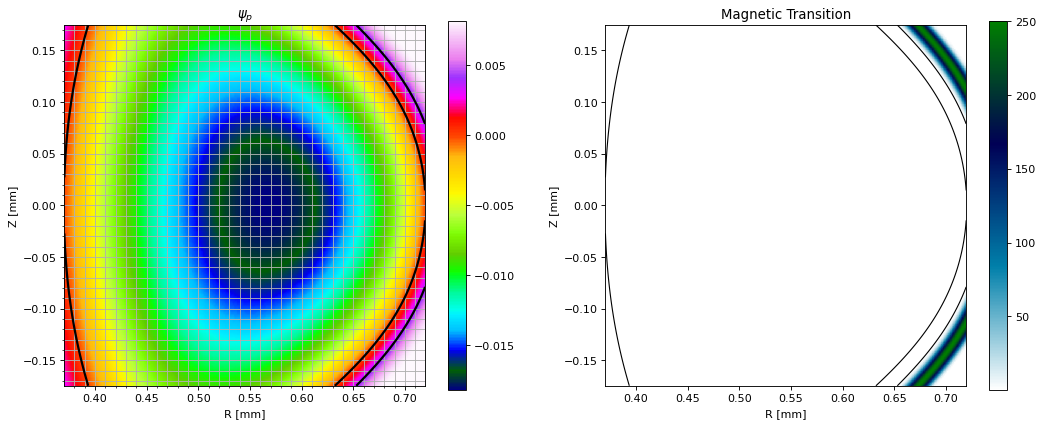

In [13]:
# 1. We plot the flux surfaces and the location of the wall
ncin = Dataset(ncfile, "r", format="NETCDF4")
print("O-point situated at", ncin.opoint)
print("X-point situated at", ncin.xpoint)
ncin.close()
plot(ncfile)

As we can see the box does not fully contain the closed fieldline region or the X-point. 
- The magnetic transition needs to be entirely inside the box except for where the divertor is supposed to be

The goal is to 
- check that $\psi_p = 0$ actually is the last closed flux surface!
- create an adequate simulation box that contains the whole region of interest
- create a wall region such that fieldlines intersect the wall as little as possible and structures can be dampened away
- wall transition region should be entirely in the box (no intersections with the boundary)



Z:R = 2.0
[1.09, 0.97, 1.01, 0.98]
Wall levels =  [0.97, 0.98, 1, 1.01, 1.09]
solovev doubleX
triangularity=0.3 elongation=1.4


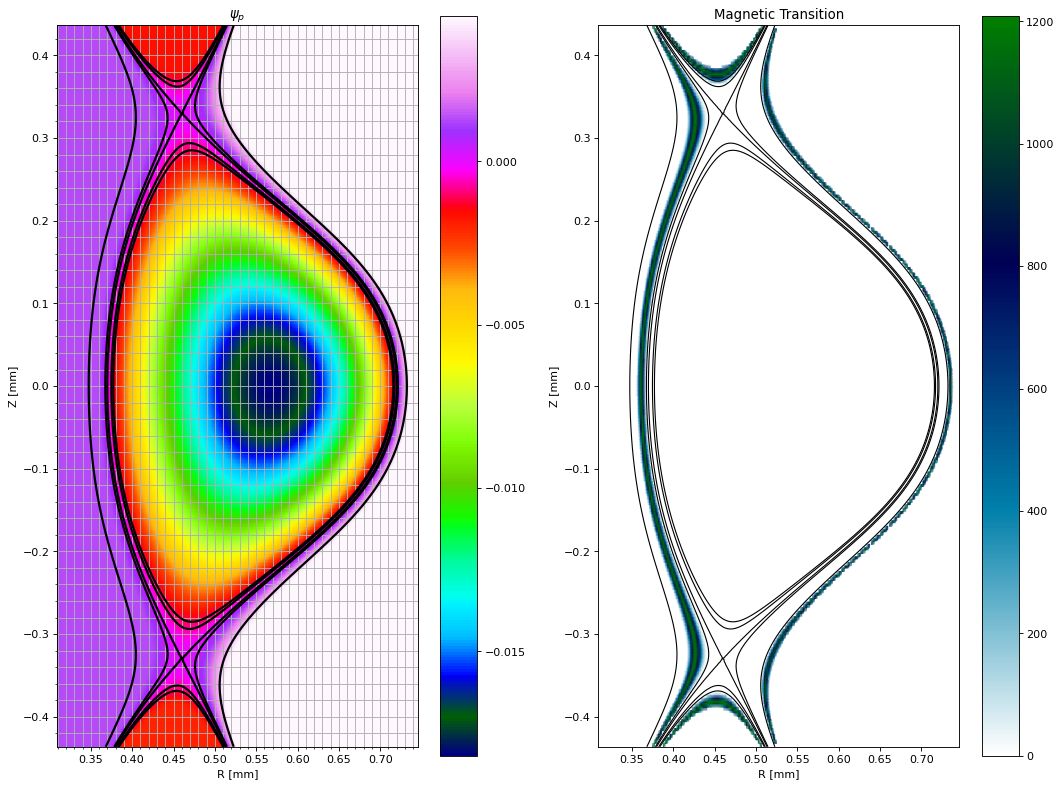

In [14]:
# Let us calibrate the wall
ifile = make_inputfile()

ifile["diagnostics"] = []

ifile["grid"]["scaleR"] = [1.35, 1.15]
ifile["grid"]["scaleZ"] = [2.5, 2.5]
ifile["boundary"]["wall"]["type"] = "sol_pfr_2X"
ifile["boundary"]["wall"]["boundary"] = [1.09, 0.97, 1.01, 0.98]
ifile["boundary"]["wall"]["alpha"] = [0.05, 0.05, 0.05, 0.05]
rep.run(ifile)
plot(ncfile)

Once the wall is setup nicely we can calibrate the sheath. Since the sheath coordinate needs to be integrated the program may take longer to execute

What to look for
- create a sheath region with distinct in- and outflow
- sheath in and outflow should not be connected


Z:R = 2.0
[1.09, 0.97, 1.01, 0.98]
Wall levels =  [0.97, 0.98, 1, 1.01, 1.09]
solovev doubleX
triangularity=0.3 elongation=1.4


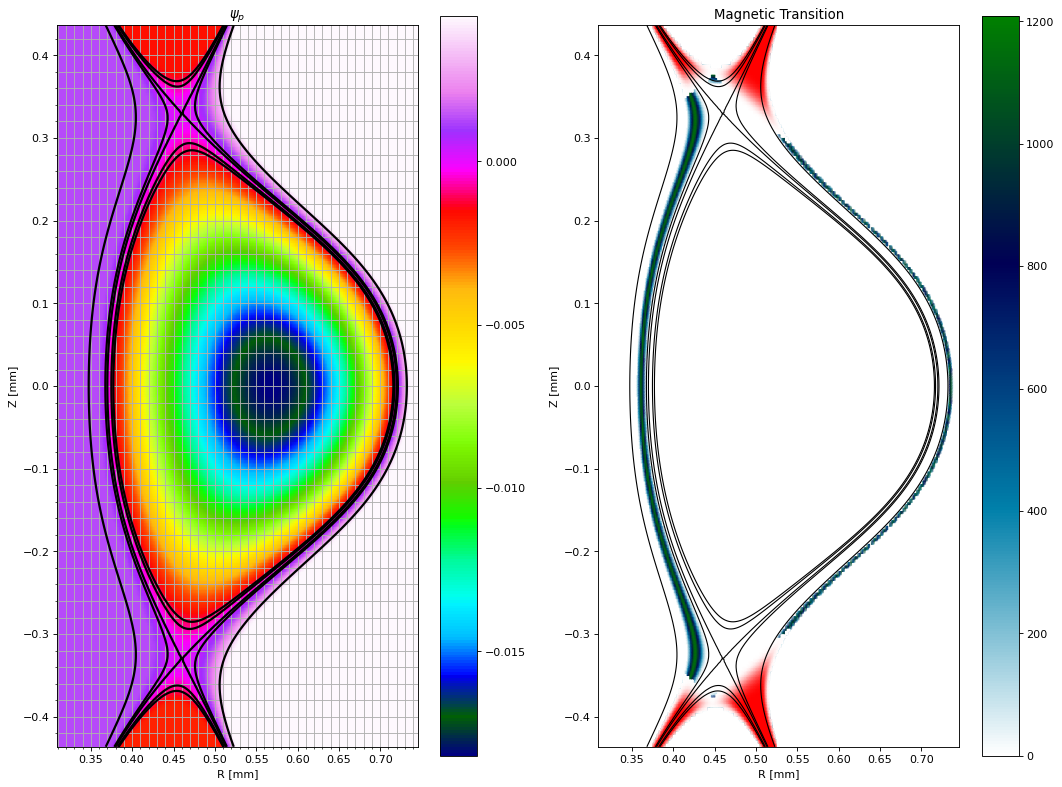

In [15]:
ifile["boundary"]["sheath"] = dict()
ifile["boundary"]["sheath"]["boundary"] = (
    7 / 32
)  # Total width of sheath in units of 2Pi
ifile["boundary"]["sheath"]["alpha"] = (
    7 / 32 - 2 / 32
)  # Transition width of sheath in units of 2Pi
ifile["boundary"]["sheath"]["max_angle"] = 0.5  # max angle in units of 2Pi
ifile["boundary"]["sheath"]["coordinate"] = "s"
ifile["diagnostics"] = ["sheath"]
rep.run(ifile)
plot(ncfile, plot_sheath=True)

## q-profile

As a bonus step we can here also plot the q-profile that the diagnostics can produce

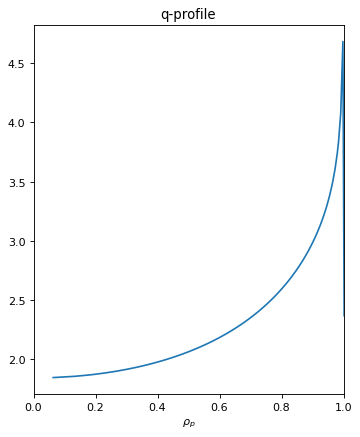

In [16]:
ifile["diagnostics"] = ["q-profile"]
rep.run(ifile)
ncin = Dataset(ncfile, "r", format="NETCDF4")
pp = json.loads(ncin.inputfile)
fig, ax = plt.subplots(
    1, 1, figsize=(1 * 5, 1 * 6), dpi=80, facecolor="w", edgecolor="k"
)
ax.plot(ncin["rho_p"][:], np.abs(ncin["q-profile"][:]))
ax.set_title("q-profile")
ax.set_xlim([0, 1])
ax.set_xlabel(r"$\rho_p$")
plt.show()

In [17]:
idx = np.abs(ncin["rho_t"][:] - 0.95).argmin()
q95 = np.asarray(ncin["q-profile"])[idx]
q95

-3.5065864408857657

WELL DONE! The next step will be to setup a simulation with the FELTOR code

In [18]:
rep.clean()